In [6]:
import torch

from ballerDataset import BallerDataset
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformerModel import BallerModel
from engine2 import train,test

from torch.nn import MSELoss

import matplotlib.pyplot as plt

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [8]:
IN_SEQ_LEN= 50
OUT_SEQ_LEN = 50
PLAYER_BALL_ENCODING_SIZE = 8   #this number *2 must be divisible by n_heads
DROPOUT = 0.5
LR = 1e-3
BATCH_SIZE = 512
EPOCHS = 5

USE_LR_SCHEDULER = True
SCHEDULER_PATIENCE = 10

In [9]:
train_path = 'data/old/train/'
validation_path = 'data/old/validation/'
test_path = 'data/new/test/'


train_dataset = BallerDataset(train_path,True)
validation_dataset = BallerDataset(validation_path,True)
test_dataset = BallerDataset(test_path,True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [10]:
model = BallerModel(player_ball_encoding_size=PLAYER_BALL_ENCODING_SIZE,
                    dropout=DROPOUT)
model = model.double()
model = model.to(device)
loss_func = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr = LR)
scheduler = ReduceLROnPlateau(optim, mode='min', patience=SCHEDULER_PATIENCE, verbose=True) if USE_LR_SCHEDULER else None

In [11]:
model.load_state_dict(torch.load('saved_models/macro5050.pt', map_location=device))

<All keys matched successfully>

In [12]:
def run_inference(model, src, forecast_window, batch_size, device):
    tgt = src[:,-1,0,:-1] # shape (batch, xy)
    tgt = tgt.unsqueeze(1) # shape (batch, seq=1, xy)
    # print(tgt[0])
    
    # Iteratively concatenate with first element in the prediction
    for _ in range(forecast_window-1):
        tgt_mask = BallerModel.generate_square_subsequent_mask(
            dim1=tgt.shape[1],
            dim2=tgt.shape[1]
        )
        src_mask = BallerModel.generate_square_subsequent_mask(
            dim1=tgt.shape[1],
            dim2=src.shape[1]
        )
        tgt_mask = tgt_mask.to(device)
        src_mask = src_mask.to(device)
        
        # prediction = model(src, tgt, src_mask, tgt_mask) # shape (batch, seq, xyz)
        prediction = model(src, tgt) # shape (batch, seq, xyz)
        
        last_pred_val = prediction[:,-1] # shape (batch, xyz)
        last_pred_val = last_pred_val.unsqueeze(1) # shape (batch, seq=1, xyz)
        
        tgt = torch.cat((tgt, last_pred_val.detach()), 1) # concat on seq dim
        # print(tgt[0])
        
    # Final prediction
    tgt_mask = BallerModel.generate_square_subsequent_mask(
            dim1=tgt.shape[1],
            dim2=tgt.shape[1]
        )
    src_mask = BallerModel.generate_square_subsequent_mask(
        dim1=tgt.shape[1],
        dim2=src.shape[1]
    )
    tgt_mask = tgt_mask.to(device)
    src_mask = src_mask.to(device)
    
    final_pred = model(src, tgt, src_mask, tgt_mask) # shape (batch, seq, xyz)
    # print(final_pred[0])
    return final_pred

In [13]:
bestVal = float('Inf')
besty = None
bestout = None
bestplayer = None

model.eval()
with torch.no_grad():
    for i, (X,y, player) in enumerate(test_dataloader):
        X = X.to(device)
        y = y.to(device)
        player = player.to(device)
        y = y[:,:,:-1]
        out = run_inference(
            model=model,
            src=X,
            forecast_window=OUT_SEQ_LEN,
            batch_size=X.shape[0],
            device=device
        )
        
        loss = torch.sqrt(MSELoss(reduction='none')(out,y))
        batchVal = loss.mean(axis=1).mean(axis=1).min()
        if batchVal < bestVal:
            bestI = loss.mean(axis=1).mean(axis=1).argmin()
            bestX = X[bestI]
            besty = y[bestI]
            bestout = out[bestI]
            bestplayer = player[bestI]
            bestVal = batchVal
        break

# Data Viz

In [14]:
bestX.shape

torch.Size([50, 11, 3])

In [15]:
besty.shape

torch.Size([50, 2])

In [16]:
bestout.shape

torch.Size([50, 2])

In [27]:
bestplayer.shape

torch.Size([50, 11, 3])

In [17]:
import matplotlib.animation as animation
import os

In [18]:
def plotSequence(X, y, out, num, save=False):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(X[:,0,0].tolist(), X[:,0,1].tolist(),  marker='o', color='blue')
    ax.scatter(X[0,0,0].tolist(), X[0,0,1].tolist(), marker='D', s=50)

    # Truth
    ax.plot([X[-1,0,0].tolist()] + y[:,0].tolist(), [X[-1,0,1].tolist()] + y[:,1].tolist(), 
             color='green', linestyle='dashed', marker='.')

    # Pred
    ax.plot([X[-1,0,0].tolist()] + out[:,0].tolist(), [X[-1,0,1].tolist()] + out[:,1].tolist(), 
             color='red', linestyle='dashed', marker='.')

    
    if save:
        path = f'vizOut/{num}'
        if not os.path.exists(path): os.mkdir(path)

        for i in range(0, 360, 6):
            ax.view_init(azim=i, elev=30)
            plt.savefig(f'{path}/out_{i}.png')

        frames = []
        for i in range(0, 360, 6):
            image = imageio.v2.imread(f'{path}/out_{i}.png')
            frames.append(image)

        print(len(frames))
        imageio.mimsave(f'{path}.gif', # output gif
                    frames,          # array of input frames
                       )
    else:
        #ax.view_init(azim=45, elev=30)
        plt.show()

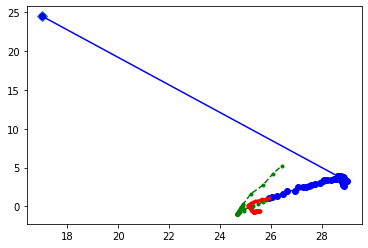

In [19]:
plotSequence(bestX, besty, bestout,17, save=False)

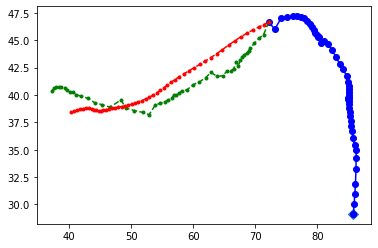

In [20]:
plotSequence(X[17], y[17], out[17],17, save=False)

In [47]:
losses= []
for i in range(512):
    loss = MSELoss()(out[i], y[i])
    losses.append((loss, i))
losses = sorted(losses)

144


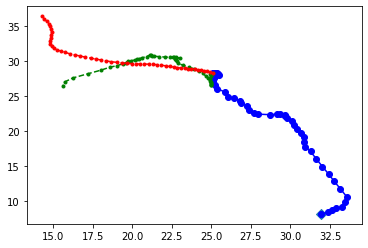

188


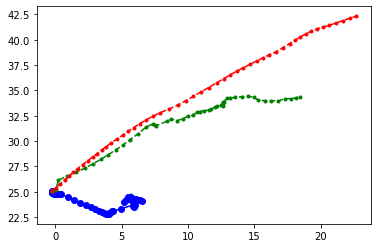

201


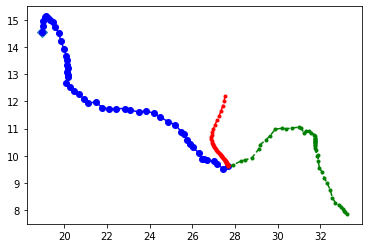

35


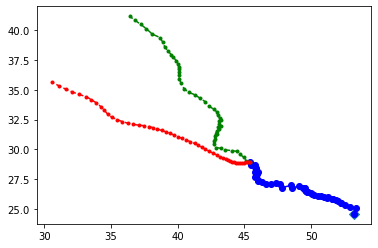

67


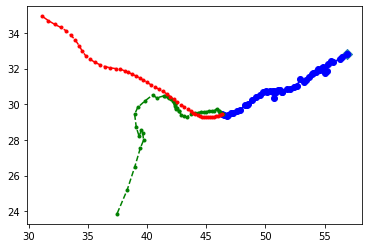

510


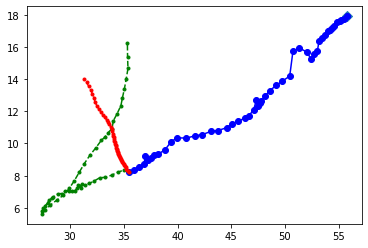

464


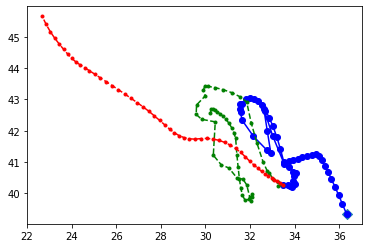

466


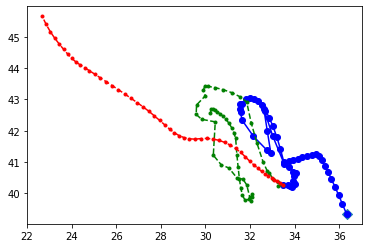

98


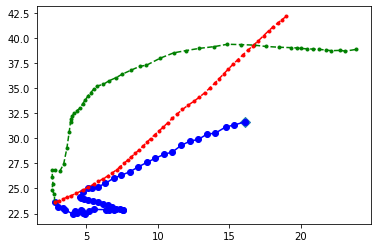

410


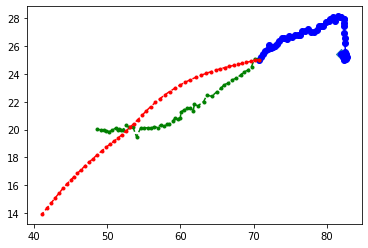

In [75]:
for x in range(30,40):
    i = losses[x][1]
    print(i)
    plotSequence(X[i], y[i], out[i],i, save=False)

In [43]:
import matplotlib.animation as animation
def simulateSequence(X, y, out, player, fname='simulation.gif'):
    X = X.cpu()
    y = y.cpu()
    out = out.cpu()
    player = player.cpu()
    
    fig = plt.figure()
    ax = fig.add_subplot()

    seq = torch.cat((X, player), dim=0)
    seq = seq[:,:,:-1] #only xy 

    smallest = torch.cat((seq.min(axis=1)[0], out), dim=0).min(axis=0)[0]
    largest = torch.cat((seq.max(axis=1)[0], out), dim=0).max(axis=0)[0]

    e = 5
    diff = (largest - smallest).max() + e*2
    diff = diff.cpu()
    mid = (largest + smallest)/2

    ze = 1

    ax.set_xlim(mid[0].item() - diff/2, mid[0].item() + diff/2)
    ax.set_ylim(mid[1].item() - diff/2, mid[1].item() + diff/2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
  

    scatters = []

    for i in range(1,11):
        scat = ax.scatter(X[0,i,0], X[0,i,1],  marker='x', color='purple' if i < 6 else 'orange')
        scatters.append(scat)

    input_ball = ax.plot([],[], marker='.', linestyle='-', color='blue')[0]
    output_ball = ax.plot([],[], marker='.', linestyle='-', color='red')[0]
    output_true_ball = ax.plot([],[], marker='.', linestyle='-', color='green')[0]

    def animate(num, scatters, input_ball, output_ball, output_true_ball):
        if num < X.shape[0]:
            for i, scat in enumerate(scatters):
                i = i+1
                scat.set_offsets((X[num,i,0].tolist(), X[num,i,1].tolist()))
            input_ball.set_data(X[:num,0,0].tolist(), X[:num,0,1].tolist())
            #input_ball.set_3d_properties(X[:num,0,2].tolist())
        else:
            num -= X.shape[0]
            for i, scat in enumerate(scatters):
                i = i+1
                scat.set_offsets((player[num,i,0].tolist(), player[num,i,1].tolist()))

            output_ball.set_data(out[:num,0].tolist(), out[:num,1].tolist())
            #output_ball.set_3d_properties(out[:num,2].tolist())
            output_true_ball.set_data(y[:num,0].tolist(), out[:num,1].tolist())
            #output_true_ball.set_3d_properties(y[:num,2].tolist())

        return

    ani = animation.FuncAnimation(fig, animate,
                                        frames=X.shape[0]+y.shape[0], fargs=[scatters, input_ball, output_ball, output_true_ball], interval=50)

    writer = animation.PillowWriter(fps=15,
                                    metadata=dict(artist='Me'),
                                    bitrate=1800)
    ani.save(fname, writer=writer)
    #plt.show()
    return

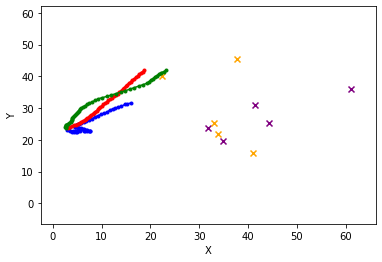

In [77]:
indexo =98
simulateSequence(X[indexo] ,y[indexo],out[indexo], player[indexo], fname='animations/simulation_good7.gif')